# Implementing: ISPA - SearchLight
This script demonstrates how to use the searchlight implementation available in nilearn to perform group-level decoding using an inter-subject pattern analysis (ISPA) scheme.


Script adapted from: https://github.com/SylvainTakerkart/inter_subject_pattern_analysis/tree/master/fmri_data

Original paper: https://doi.org/10.1016/j.neuroimage.2019.116205

Dataset: https://doi.org/10.1371/journal.pone.0250487

## Importing packages

In [ ]:
import pandas as pd
import numpy as np
import os
import os.path as op
import re
import glob
import tarfile
import urllib

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression

from nilearn.image import new_img_like, concat_imgs, clean_img
from nilearn.decoding import SearchLight

import nibabel as nb


## Opening files to work with
It's important to notice that the beta files are expected to be at the trial level. 

In [ ]:
# Set the path to your GLM directory
data_dir = '/your_path/GLM'

# getting a full list of available subjects
files = os.listdir(data_dir)
pattern = r'sub-(\d+)_LSA'
subject_numbers = [re.search(pattern, file_name).group(1) for file_name in files if re.search(pattern, file_name)]
#subject_numbers = ['3120', '0196']
beta_flist = []
y = []
subj_vect = []
runs = []
        
# Create lists from beta map filenames in 'beta_flist', labels in 'y', and subject numbers in 'subj_vect'.
for subject_number in subject_numbers:
    subject_directory = os.path.join(data_dir, f'sub-{subject_number}_LSA')
   
    # List beta map files for the current subject
    beta_map_files = glob.glob(os.path.join(subject_directory, f'sub-{subject_number}_run*_*.nii.gz'))
    beta_map_files.sort()
    beta_flist.extend(beta_map_files)
   
    # Extract the label from the beta map filename
    for beta_map_file in beta_map_files:
        label = beta_map_file.split('_')[-3]  # Assumes label is the third part of the filename
        if "InfOther" in label: # Adjustlabels to consider Own vs. Other (irrelevant to valence) 
            label= "Other"
        elif "InfOwn" in label:
            label= "Own"
        y.append(label)
        subj_vect.append(subject_number)
        
    # Extract run info from the beta map filename (to be used in standardization)
    for beta_map_file in beta_map_files:
        run = beta_map_file.split('_')[-4]  # Assumes run is the second part of the filename
        runs.append(run)

# Standardization (per run and subject)

In [ ]:
# read image data
print("Reading beta maps from all the subjects...")

fmri_nii_dict = {}

for beta_path in beta_flist:
    parts = re.split(r'[/_]', beta_path)
    subj = parts[-6]
    run = 'run-'+parts[-4]
    condition = parts[-3]
    beta = parts[-2]
    
    image = nb.load(beta_path)
    
    # Check if the subject already exists in the dictionary
    if subj in fmri_nii_dict:
        # If the run exists for the subject, append the data to the existing list
        if run in fmri_nii_dict[subj]:
            fmri_nii_dict[subj][run].append({'condition': condition, 'beta': beta, 'image': image})
        # If the run doesn't exist, create a new entry for the run
        else:
            fmri_nii_dict[subj][run] = [{'condition': condition,'beta': beta, 'image': image}]
    # If the subject doesn't exist, create a new entry for the subject and run
    else:
        fmri_nii_dict[subj] = {run: [{'condition': condition,'beta': beta, 'image': image}]}

# Printing the created dictionary
for subj, subj_value in fmri_nii_dict.items():
    for run, run_value in subj_value.items():
        print(f"Subject: {subj}, Run: {run}")
        for item in run_value:
            print(item)
        print('\n')



In [ ]:
concat_imgs_dict = {}
concat_imgs_stand_dict = {}

# Concatenating the images for the same run and subject
for subj, subj_value in fmri_nii_dict.items():
    for run, run_value in subj_value.items():
        images_to_concat = [item['image'] for item in run_value]
        concatenated_image = concat_imgs(images_to_concat)
        print(f"Subject: {subj}, Run: {run}, Concatenated Beta Images Shape: {concatenated_image.shape}")
        
        # Adding concatenated image to the concat_imgs_dict
        if subj in concat_imgs_dict:
            concat_imgs_dict[subj][run] = concatenated_image
        else:
            concat_imgs_dict[subj] = {run: concatenated_image}

        # Standardized beta maps with clean_img()
        stand_image = clean_img(concatenated_image, standardize=True, detrend=False)
        print(f"Subject: {subj}, Run: {run}, Concatenated Standardized Beta Images Shape: {stand_image.shape}")
        
        # Adding standardized image to the concat_imgs_stand_dict
        if subj in concat_imgs_stand_dict:
            concat_imgs_stand_dict[subj][run] = stand_image
        else:
            concat_imgs_stand_dict[subj] = {run: stand_image}

In [ ]:
# Concatenate all subjects 

all_images_to_concat = []
for subj, subj_value in concat_imgs_stand_dict.items():
    for run, stand_image in subj_value.items():
        all_images_to_concat.append(stand_image)

all_betas_stand = concat_imgs(all_images_to_concat)

print(f"All Betas Stand Shape: {all_betas_stand.shape}")


# Adjust Masks 

In [ ]:
from nilearn.image import math_img, new_img_like, concat_imgs, resample_to_img

# reading brain mask
mask_brain = nb.load("/your_path/brain_mask.nii.gz")

# Check whether ROI and Betas are in the same space and resample if necessary
beta_img = nb.load(beta_map_files[0])
if not beta_img.shape == mask_brain.shape:
    resampled_mask_brain = resample_to_img(mask_brain, beta_img)
print("Shape of original Beta image: %s" % (beta_img.shape,))
print("Shape of original ROI image: %s" % (mask_brain.shape,))
print("Shape of resampled ROI image: %s" % (resampled_mask_brain.shape,))

# Setting up for leave-one-subject-out cross-validation 

In [ ]:
# set up leave-one-subject-out cross-validation
loso = LeaveOneGroupOut()
unique_subjects = np.unique(subj_vect)
n_splits = loso.get_n_splits(groups=unique_subjects)

In [ ]:
# output directory
output_dir = "/your_path/ISPA_SearchLight"
os.makedirs(output_dir, exist_ok=True)

# Calculate the chance level
chance_level = 1. / len(np.unique(y))

# running searchlight decoding
searchlight_radius = 4
n_jobs = -1
y = np.array(y)
single_split_path_list = []
print("Launching cross-validation...")
for split_ind, (train_inds,test_inds) in enumerate(loso.split(subj_vect,subj_vect,subj_vect)):
    print("...split {:02d} of {:02d}".format(split_ind+1, n_splits))
    single_split = [(train_inds,test_inds)]
    y_train = y[train_inds]
    n_samples = len(y_train)
    class_labels = np.unique(y_train)
    clf = LogisticRegression()
    searchlight = SearchLight(resampled_mask_brain,
                              #process_mask_img=resampled_ROI,
                              radius=searchlight_radius,
                              n_jobs=n_jobs,
                              verbose=1,
                              cv=single_split,
                              estimator=clf)
    print("...mapping the data (this takes a long time) and fitting the model in each sphere")
    searchlight.fit(all_betas_stand, y)

    single_split_nii = new_img_like(resampled_mask_brain,searchlight.scores_ - chance_level)
    single_split_path = op.join(output_dir, 'ispa_searchlight_accuracy_split{:02d}of{:02d}.nii'.format(split_ind+1,n_splits))
    print('Saving score map for cross-validation fold number {:02d}'.format(split_ind+1))
    single_split_nii.to_filename(single_split_path)
    single_split_path_list.append(single_split_path)

# Trying to do Non-parametric Permutations with nilearn
Originally it was performed with SnPM MATLAB toolbox to analyse the single-fold (for the inter-subject cross-validation of ISPA) accuracy maps, with 1000 permutations and a significance threshold (p<0,05, FWE corrected).
Here, we are trying to do the same, but using nilearn.

Original SnPM batch: https://github.com/SylvainTakerkart/inter_subject_pattern_analysis/blob/master/fmri_data/snpm_batch.m

In [1]:
 # Under construction

# Generating figures of sinificant brain regions from SnPM


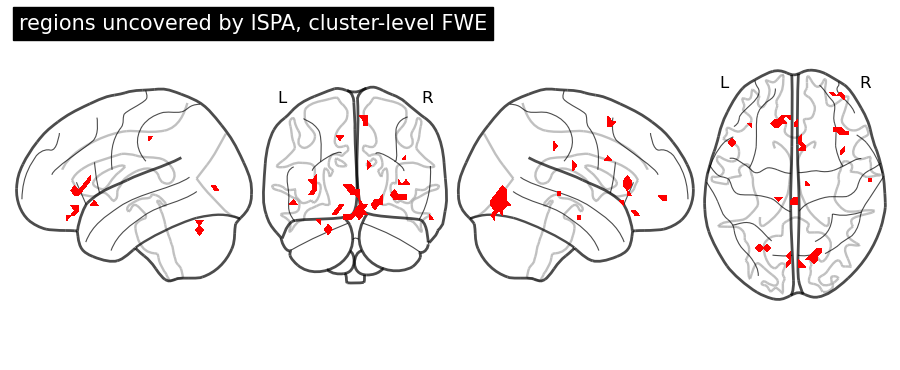

In [16]:
from nilearn import plotting
import nibabel as nb


result_dir = '/your_path/snpm_batch_cluster_level'

brain_nii = nb.load(result_dir + '/SnPM_filtered.nii')
display = plotting.plot_glass_brain(None, display_mode='lyrz')
color = 'r'
display.add_contours(brain_nii, filled=True, levels=[1], colors=color)
display.title('regions uncovered by ISPA, cluster-level FWE')
#display.savefig(result_dir + '/{}_{}.png'.format(dataset_name, decoding_type))